In [106]:
import sys
sys.path.append("../..")

#Defining libraries
import os
import pandas as pd
import numpy as np
import rasterio
from collections import defaultdict
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.stats import pearsonr
from rasterio.windows import from_bounds
import gc


In [2]:
'''
1-11-> Residential urban areas 
2-121,13->Industrial and abbandoned urban areas
3-122,123,124 Transportation infrastructure (streets, highways, airports, and ports)
4-14->Urban green areas
5-2->Agricultural areas
6-3->Forest
7-4/5->Hydro and humid bodies
'''
#Convert from copernicus code 2018 to an internal code
URBAN = 1
INDUSTRIAL = 2
TRANSPORTATION = 3
URBAN_VEGETATION = 4
RURAL = 5
FOREST = 6
WATER = 7
LC_NO_DATA = 9999
NO_DATA= -9999
    
# Function to check if the file is a tiff and must be read.
def check_wrong_files(f):
    if f == 'clip': return True #avoid entering the "clip" folder
    if 'csv'in f: return True
    if f in ['2017']: return True #Not consider the 2017 image as it biases the model
    if 'ipynb' in f: return True #avoid entering the "ipynb_checkpoint" file
    if 'tar' in f: return True #avoid entering "tar" files
    if 'aux' in f: return True #avoid entering "aux" files
    return False

def match_landsat_to_landcover(landsat):
    year = int(landsat)
    if year in [2015,2016]:
        return str(2015)
    elif year in [2017,2018,2019]:
        return str(2018)
    elif year in [2020,2021,2022]:
        return str(2021)

In [3]:
# City parameters and global variables
city_info = {
    "resolution": 5,
    "epsg": 32632,
    "capitalized": "Milan"
}

city = 'MILANO'
current_city_info = city_info
city_epsg = current_city_info['epsg']
data_folder = "data"
#landcover_path = f'{landcover_base_path}/DUSAF_MCM_mapped_{year}.tif'

landsat_raster_folder = "/home/user/ODC_harmonia/Landsat/Milan/data"
sat_images_path = f"{landsat_raster_folder}/clip"
file_list = os.listdir(f"{sat_images_path}")
landcover_base_path = f'{data_folder}/landcover'
#landsat_raster_file_list = os.listdir(f"{landsat_raster_folder}")
lst_folder = f"{landsat_raster_folder}/summer_avg"
total_samples_per_raster = 30000


## Landsat-8 summer mosaics 2015-2022 (excl 2017)

In [4]:
all_scenes_df = pd.read_csv(f'{lst_folder}/all_scenes_summer_avg_temp_stats_per_class.csv')

In [5]:
all_scenes_df

,scene,landcover_class,avg_temp,min_temp,max_temp,std_temp,q1_temp,q3_temp
0,2016,1,313.88547,300.35846,325.96286,2.284621,312.601807,315.491760
1,2016,2,314.59860,297.78986,331.71368,3.423570,312.400146,316.857239
2,2016,3,313.67392,302.34090,325.35272,2.973420,311.624268,315.703674
3,2016,4,311.33908,301.43515,323.50702,2.774362,309.460663,313.292236
4,2016,5,307.93744,300.11237,325.79196,2.653560,305.840973,309.744354
...,...,...,...,...,...,...,...,...
59,2018,4,312.93723,292.55344,327.11646,3.326754,310.983398,315.190979
60,2018,5,307.46094,291.89374,324.08978,4.014516,304.926636,310.120331
61,2018,6,305.55466,291.01874,324.17523,5.112056,301.843597,309.282898
62,2018,7,305.84714,291.43230,319.21912,3.774375,304.068726,307.900330


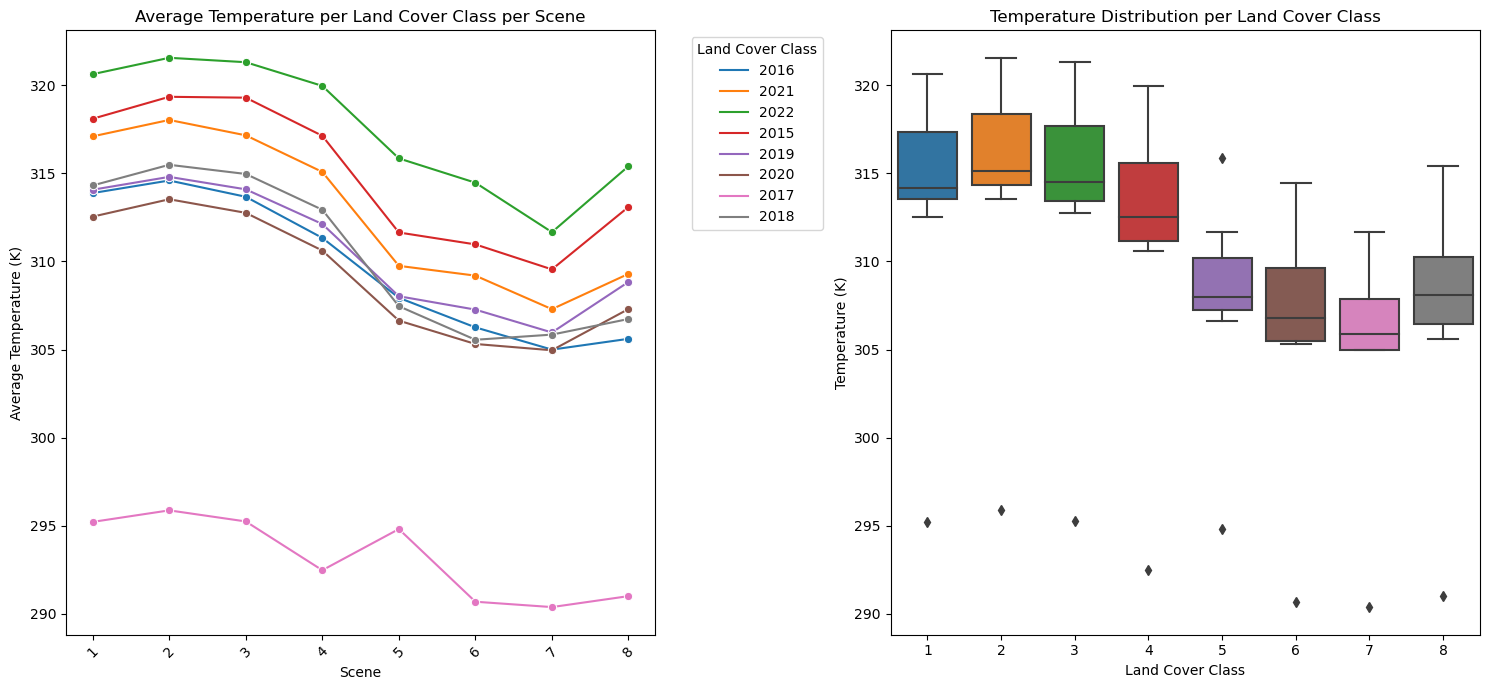

In [6]:

# Assuming `all_scenes_df` is your DataFrame with the computed stats
# First, ensure the scene column is treated as categorical for better plotting
all_scenes_df['scene'] = pd.Categorical(all_scenes_df['scene'], categories=all_scenes_df['scene'].unique(), ordered=True)

# Create the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# --- Linear Plot (Average Temperature per Land Cover Class per Scene) ---
sns.lineplot(x='landcover_class', y='avg_temp', hue='scene', data=all_scenes_df, ax=axes[0], marker='o')
axes[0].set_title('Average Temperature per Land Cover Class per Scene')
axes[0].set_xlabel('Scene')
axes[0].set_ylabel('Average Temperature (K)')
axes[0].legend(title='Land Cover Class', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)

# --- Box Plot (Distribution of Temperature per Land Cover Class) ---
sns.boxplot(x='landcover_class', y='avg_temp', data=all_scenes_df, ax=axes[1])
axes[1].set_title('Temperature Distribution per Land Cover Class')
axes[1].set_xlabel('Land Cover Class')
axes[1].set_ylabel('Temperature (K)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

getting LST images

In [113]:
def get_raster_statistics(variable):
    lst_folder = f"{landsat_raster_folder}/summer_avg"
    lst_file_list = os.listdir(f"{lst_folder}")
    data = {
        '2015': None,
        '2016': None,
        '2018': None,
        '2019': None,
        '2020': None,
        '2021': None,
        '2022': None,
    }

    for f in lst_file_list:
        if check_wrong_files(f): continue

        try:
            year = str(f)
            lst_path = f"{lst_folder}/{f}/{variable}_{year}.tif"
            with rasterio.open(lst_path, driver="GTiff") as lst_raster:
                lst_array = lst_raster.read(1)
                #print(lst_raster.profile)
                rows, cols = lst_array.shape
                x_positions = np.arange(0, cols)
                y_positions = np.arange(0, rows)
                x, y = np.meshgrid(x_positions, y_positions)
                x_flat = x.flatten()
                y_flat = y.flatten()
                values_flat = lst_array.flatten()

                # Create a DataFrame for the lst
                lst_df = pd.DataFrame({variable: values_flat})
                lst_df = lst_df.replace({-9999: np.nan})
                data[year] = lst_df.describe()
                gc.collect()

        except Exception as e: 
            print(e)   
    return data

In [115]:
def process_raster_data(data, variable):
    years = ['2015', '2016', '2018', '2019', '2020', '2021', '2022']
    df_data = {
        "year": years,
        "mean": [],
        "std": [],
        "q1": [],
        "q2": [],
        "q3": []
    }

    for year in years:
        if data[year] is not None:
            df_data["mean"].append(list(data[year][variable])[1])
            df_data["std"].append(list(data[year][variable])[2])
            df_data["q1"].append(list(data[year][variable])[4])
            df_data["q2"].append(list(data[year][variable])[5])
            df_data["q3"].append(list(data[year][variable])[6])

    data_df = pd.DataFrame(df_data)
    return data_df

In [119]:
def box_plot(df, variable):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.xlabel("Year")
    plt.ylabel(variable)
    plt.title(f"{variable} Distribution (2015-2022)")
    plt.xticks(rotation=45)
    plt.grid(True)

In [128]:
raster_data['uhi_int']

{'2015':             uhi_int
 count  6.207348e+07
 mean   2.940268e+00
 std    5.285849e+00
 min   -1.515347e+01
 25%   -1.598755e+00
 50%    3.541931e+00
 75%    7.281281e+00
 max    2.218497e+01,
 '2016':             uhi_int
 count  6.207193e+07
 mean   2.566475e+00
 std    4.186666e+00
 min   -1.070514e+01
 25%   -8.612366e-01
 50%    2.238892e+00
 75%    5.887634e+00
 max    2.399460e+01,
 '2018':             uhi_int
 count  6.210128e+07
 mean   3.122330e+00
 std    5.483671e+00
 min   -1.617664e+01
 25%   -1.135620e+00
 50%    3.124939e+00
 75%    7.691406e+00
 max    2.526855e+01,
 '2019':             uhi_int
 count  6.210386e+07
 mean   2.599212e+00
 std    4.595635e+00
 min   -1.134293e+01
 25%   -1.427246e+00
 50%    2.703461e+00
 75%    6.384674e+00
 max    2.387296e+01,
 '2020':             uhi_int
 count  6.208296e+07
 mean   2.656381e+00
 std    4.376401e+00
 min   -1.015347e+01
 25%   -1.088898e+00
 50%    2.717102e+00
 75%    6.241058e+00
 max    2.344055e+01,
 '2021':  

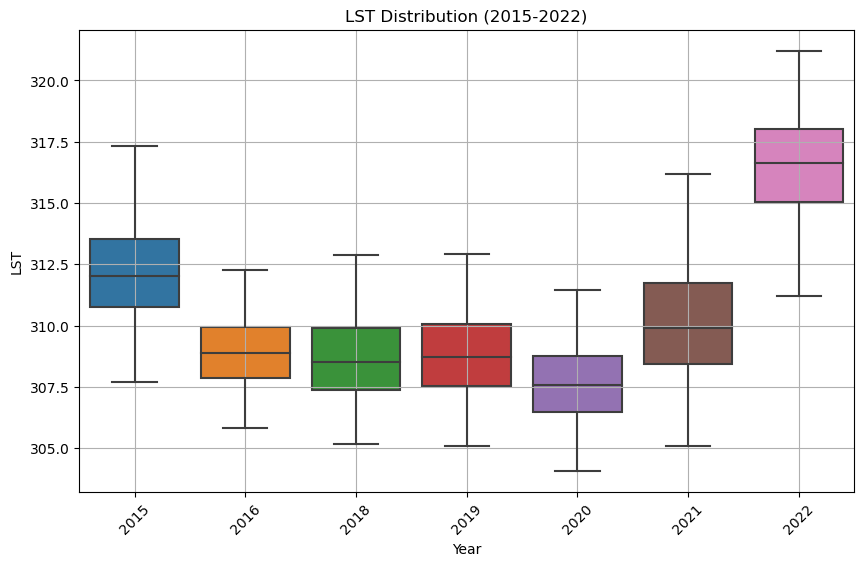

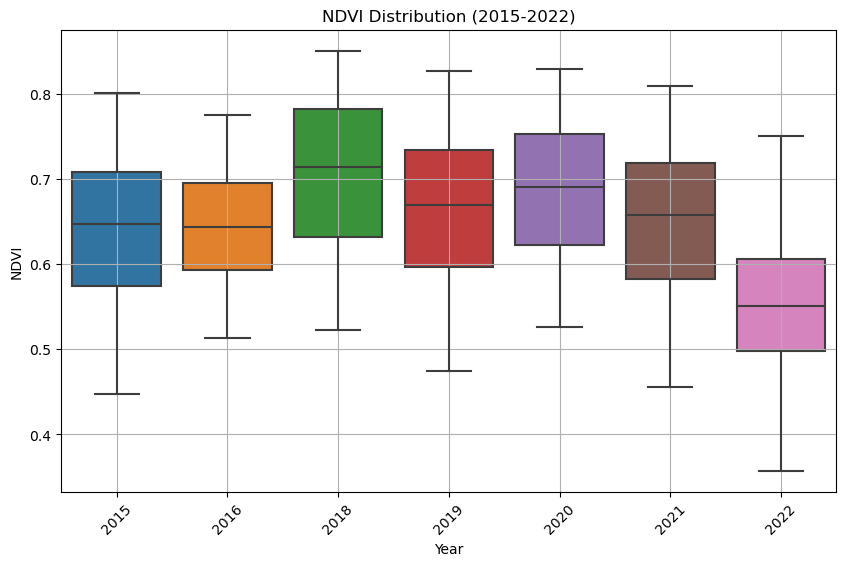

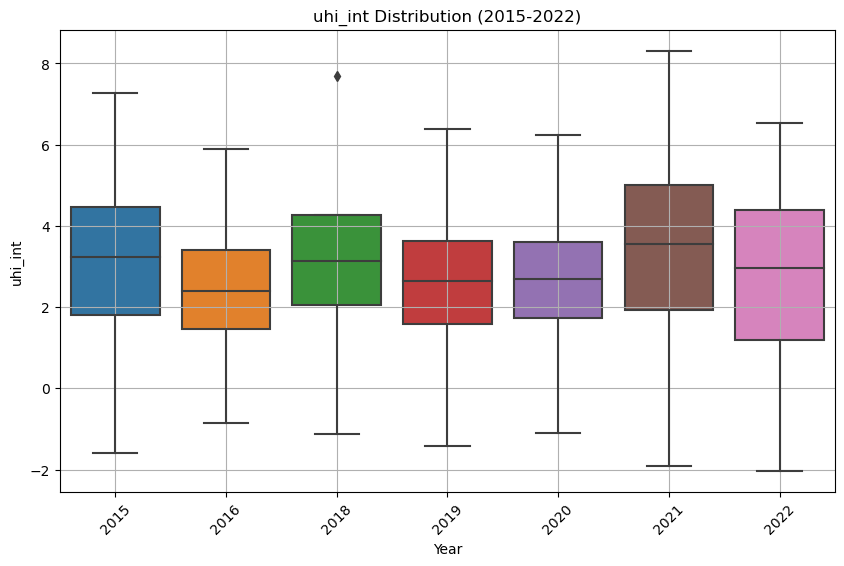

In [120]:
variables = ['LST', 'NDVI','uhi_int']
raster_data = {}
for variable in variables:
    raster_data[variable] = get_raster_statistics(variable)
    data_df = process_raster_data(raster_data[variable],variable)
    data_df_to_plot_no_std = data_df[['year','mean', 'q1', 'q2', 'q3']].set_index('year').T
    #data_df_to_plot = data_df.set_index('year').T
    box_plot(data_df_to_plot_no_std, variable)


In [126]:
def perform_raster_correlation(variable):
    # Path to your Landsat 8 LST rasters
    lst_folder = f"{landsat_raster_folder}/summer_avg"
    lst_file_list = os.listdir(lst_folder)

    # Mapping year to file paths
    year_files = {}
    for f in lst_file_list:
        if check_wrong_files(f): continue  # Ignore invalid files
        try:
            year = str(f)
            lst_path = f"{lst_folder}/{f}/{variable}_{year}.tif"
            year_files[year] = lst_path
        except Exception as e:
            print(f"Error processing {f}: {e}")

    # Get unique years
    years = list(year_files.keys())

    #  Compute pairwise correlation while managing memory
    correlation_results = []

    landcover_path = f'{landcover_base_path}/DUSAF_2021_MCM_mapped.tif'
    with rasterio.open(landcover_path) as src:
        window_bounds = src.bounds

    #Read each couple of rasters at a time to perform correlation - memory is released each iteration
    for y1, y2 in itertools.combinations(years, 2):
        try:
            with rasterio.open(year_files[y1], driver="GTiff") as lst_raster1_src, rasterio.open(year_files[y2], driver="GTiff") as lst_raster2_src:
                window1 = from_bounds(*window_bounds, transform=lst_raster1_src.transform)
                window2 = from_bounds(*window_bounds, transform=lst_raster2_src.transform)
                lst_raster1 = lst_raster1_src.read(
                    1,
                    window=window1,
                    boundless=True,
                    fill_value=0
                ).astype(np.float32)  
                lst_raster2 = lst_raster2_src.read(
                    1,
                    window=window2,
                    boundless=True,
                    fill_value=0
                ).astype(np.float32)  

                # Read raster arrays
                lst_array1 = lst_raster1
                lst_array2 = lst_raster2
                
                if variable == 'NDVI':
                    lst_array1 = np.where((lst_array1 < -1) | (lst_array1 > 1), lst_raster1_src.nodata, lst_array1)
                    lst_array2 = np.where((lst_array2 < -1) | (lst_array2 > 1), lst_raster2_src.nodata, lst_array2)
                # Mask out NoData values
                nodata1 = lst_raster1_src.nodata
                nodata2 = lst_raster2_src.nodata
                
                if nodata1 is not None and nodata2 is not None:
                    mask = (lst_array1 != nodata1) & (lst_array2 != nodata2)
                else:
                    mask = np.ones_like(lst_array1, dtype=bool)

                # Extract valid pixel values
                valid_pixels1 = lst_array1[mask]
                valid_pixels2 = lst_array2[mask]

                # Compute Pearson correlation if enough valid pixels exist
                if len(valid_pixels1) > 10 and len(valid_pixels2) > 10:
                    correlation, _ = pearsonr(valid_pixels1, valid_pixels2)
                else:
                    correlation = None

                # Store results
                correlation_results.append({
                    "Year 1": y1,
                    "Year 2": y2,
                    "Pearson Correlation": round(correlation, 3) if correlation else "N/A"
                })

                # Free memory
                del lst_array1, lst_array2, valid_pixels1, valid_pixels2, mask
                gc.collect()

        except Exception as e:
            print(f"Error processing {y1} and {y2}: {e}")
    
    df_corr = pd.DataFrame(correlation_results)
    years = sorted(set(df_corr["Year 1"]).union(set(df_corr["Year 2"])))
    corr_matrix = pd.DataFrame(index=years, columns=years, dtype=float)

    # Fill the correlation matrix
    for _, row in df_corr.iterrows():
        y1, y2, corr = row["Year 1"], row["Year 2"], row["Pearson Correlation"]
        corr_matrix.loc[y1, y2] = corr
        corr_matrix.loc[y2, y1] = corr

    # Fill diagonal with 1s (self-correlation)
    for year in years:
        corr_matrix.loc[year, year] = 1.0

    #  Convert matrix to numeric type
    corr_matrix = corr_matrix.astype(float)
    return corr_matrix

In [122]:

def plot_correlation_matrix(corr_matrix, variable):
    #  Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
    plt.title(f"{variable} Pearson Correlation Matrix")
    plt.show()

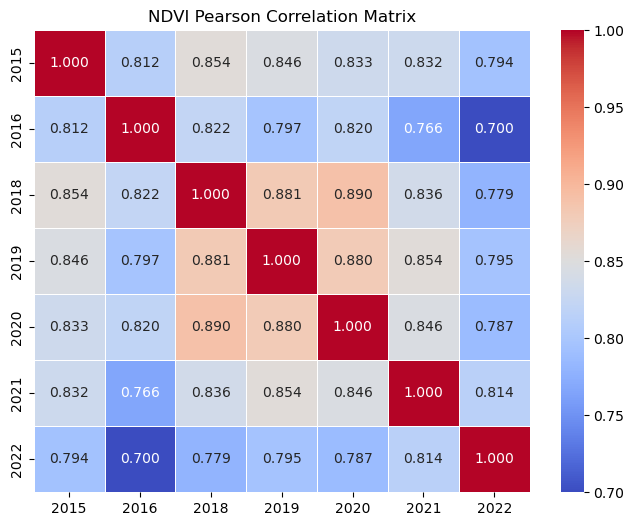

In [127]:
corr_data_NDVI= perform_raster_correlation('NDVI')
plot_correlation_matrix(corr_data_NDVI, 'NDVI')

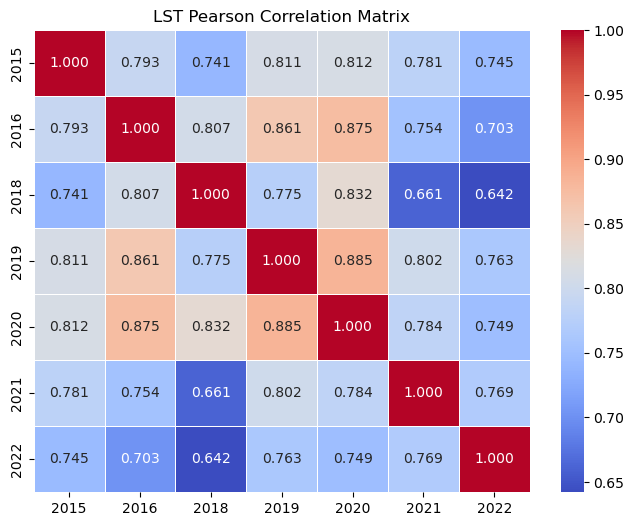

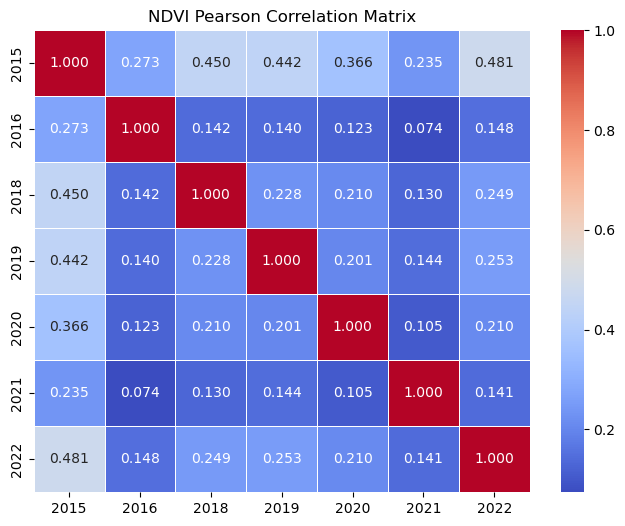

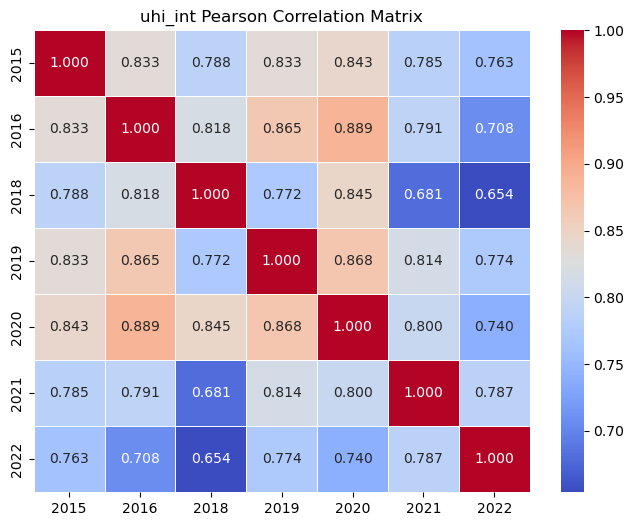

In [123]:
variables = ['LST', 'NDVI','uhi_int']
corr_data = {}
for variable in variables:
    corr_data[variable] = perform_raster_correlation(variable)
    plot_correlation_matrix(corr_data[variable], variable)